# Example of HeavyDB UDF/UDTF: Black-Scholes Model

The aim of this notebook is to demonstrate how one can enhance HeavyDB capabilities with UDF (User-Defined Functions) and UDTF (User-Defined Table Functions). For that end, we will demonstrate how one can create, register and invoke UDFs/UDTFs using [RBC](https://github.com/xnd-project/rbc) and [Numba](https://github.com/numba/numba).

## Black-Scholes Model

The [Black-Scholes model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) describes the price of an option over time. 

$C(S_t, t) = N(d_1)S_t - N(d_2)PV(K)$

$d_1 = \frac{1}{\sigma \sqrt{T - t}} [\ln(\frac{S_t}{K}) + (r + \frac{\sigma^2}{2})(T - t)]$

$d_2 = d_1-\sigma \sqrt{T-t}$

$PV(K) = K e^{-r(T-t)}$

where
* $N$ is the standard normal cummulative distribution function (CDF)
* $T-t$ is the time to maturity
* $S$ is the spot price
* $K$ is the strike price
* $r$ is the risk-free rate
* $\sigma$ is the volatity of returns of the underlying asset.

## Connecting to the HeavyDB server

Let's establish a connection to the HeavyDB server

In [31]:
import warnings; warnings.filterwarnings('ignore')

In [32]:
# NBVAL_IGNORE_OUTPUT
import rbc
print(f'Running with rbc version {rbc.__version__}')
from rbc.heavydb import RemoteHeavyDB
heavydb = RemoteHeavyDB(user='admin', password='HyperInteractive',
                        host='127.0.0.1', port=6274)
print(f'Connecting to HeavyDB version {heavydb.version}')
assert heavydb.version[:3] >= (5, 4, 0), heavydb.version

Running with rbc version 0.9.1+64.g86ada05.dirty
Connecting to HeavyDB version (7, 0, 0, 'dev-20230310-d961893816')


This notebook requires HeavyDB version 5.4 or newer and rbc version 0.4 or newer. If the above fails or one is connected to older version of HeavyDB, please resolve the issue before continuing.

## Test Data

For this notebook, we will simulate a financial Black-Scholes model using using data from the following website:
- http://www.scientific-consultants.com/nnbd.html

Read and adjust the test data

In [33]:
import pandas as pd

# Data taken from
# http://www.scientific-consultants.com/nnbd.html
df = pd.read_csv('data_black_scholes.csv', sep=',')
df['S'] = 100.0
df['r'] = 0.0
df['TIME'] = df['TIME'] / 252
df.tail()

,FCTNO,VLTY,TIME,STRIKE,OPRICE,S,r
1525,1526,2.0,0.059524,121.0,12.3662,100.0,0.0
1526,1527,2.0,0.059524,122.0,12.1061,100.0,0.0
1527,1528,2.0,0.059524,123.0,11.8515,100.0,0.0
1528,1529,2.0,0.059524,124.0,11.6021,100.0,0.0
1529,1530,2.0,0.059524,125.0,11.3580,100.0,0.0


Create a table named "black_scholes" in the database:

In [34]:
# NBVAL_IGNORE_OUTPUT
SQL=lambda query: list(heavydb.sql_execute(query)[1])
SQL('drop table if exists black_scholes')
SQL('create table if not exists black_scholes ('
    ' S DOUBLE, X DOUBLE, T DOUBLE, r DOUBLE,'
    ' sigma DOUBLE, OPRICE DOUBLE);');

Insert data into the database:

In [20]:
S = df['S']
X = df['STRIKE']
T = df['TIME']
r = df['r']
sigma = df['VLTY']
OPRICE = df['OPRICE']
heavydb.load_table_columnar('black_scholes', S=S, X=X, T=T, r=r, sigma=sigma, OPRICE=OPRICE)

Verify that the table **black_scholes** contains the data:

In [21]:
result = SQL('SELECT X, T, sigma, OPRICE FROM black_scholes;')
df2 = pd.DataFrame(result, columns=['STRIKE', 'TIME', 'VLTY', 'OPRICE'])
df2.tail()

,STRIKE,TIME,VLTY,OPRICE
1525,121.0,0.059524,2.0,12.3662
1526,122.0,0.059524,2.0,12.1061
1527,123.0,0.059524,2.0,11.8515
1528,124.0,0.059524,2.0,11.6021
1529,125.0,0.059524,2.0,11.3580


In [22]:
result = SQL('SELECT COUNT(*) FROM black_scholes;')
print(f'Number of rows: {result[0]}')

Number of rows: (1530,)


## Why use UDF/UDTF?

For large datasets, retrieving the data from the server might not be viable due to hardware and/or network limitation. In those cases, makes sense to do the computation in the server rather than locally.

HeavyDB server v5.4 implements support for users to define UDFs and UDTFs. The former applies a function to a table data row-by-row while the latter is applied to an entire column.

The UDFs and table functions can be defined as Python functions using the [RBC](https://github.com/xnd-project/rbc/) tool that exploits [Numba](https://github.com/numba/numba) to convert Python functions to [LLVM intermediate representation](https://en.wikipedia.org/wiki/LLVM) and these are registered in the HeavyDB server.

## Compute the Black-Scholes model remotely using HeavyDB UDFs

The following cells will register a function to be called from inside HeavyDB

In [23]:
import numba
import math
from rbc.stdlib import array_api as np

Define a standard normal CDF using `@numba.njit` decorator that allows calling the CDF from HeavyDB UDF/UDTFs:

In [24]:
@numba.njit
def cnd_numba(d):
    A1 = 0.31938153
    A2 = -0.356563782
    A3 = 1.781477937
    A4 = -1.821255978
    A5 = 1.330274429
    RSQRT2PI = 0.39894228040143267793994605993438
    K = 1.0 / (1.0 + 0.2316419 * math.fabs(d))
    ret_val = (RSQRT2PI * math.exp(-0.5 * d * d) *
               (K * (A1 + K * (A2 + K * (A3 + K * (A4 + K * A5))))))
    if d > 0:
        ret_val = 1.0 - ret_val
    return ret_val

Next, we'll define a function `black_scholes_UDF` that evaluates the Black-Scholes formula. The function will be registered with HeavyDB server so that one can use it in a SQL query. Notice the `@heavydb` decorator takes the signature of the function as argument:
- `@heavydb(<signature string>)` or `@heavydb(<list of signature strings>)`

In the example below, `black_scholes_UDT` accepts five `double` arguments `(S, X, T, r, sigma)` and returns a `double` value:

In [25]:
@heavydb('double(double, double, double, double, double)')
def black_scholes_UDF(S, X, T, r, sigma):
    d1 = (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    cndd1 = cnd_numba(d1)
    cndd2 = cnd_numba(d2)

    expRT = math.exp((-1. * r) * T)
    
    callResult = (S * cndd1 - X * expRT * cndd2)
    return callResult

The following cell illustrates a usage of `black_scholes_UDF` in a SQL query to HeavyDB server and compares the results with expected model values:

In [26]:
result = SQL('SELECT OPRICE,'
             ' black_scholes_UDF(S, X, T, r, sigma) FROM black_scholes;')
oprice = []
for expected, output in result:
    oprice.append(output)
    if len(oprice) < 5:
        print(f'Expected = {expected:.2f}, UDF Model output = {output:.2f}')

Expected = 25.00, UDF Model output = 25.00
Expected = 24.00, UDF Model output = 24.00
Expected = 23.00, UDF Model output = 23.00
Expected = 22.00, UDF Model output = 22.00


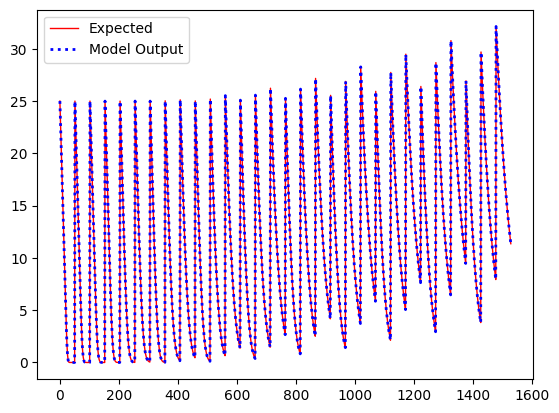

In [27]:
# NBVAL_IGNORE_OUTPUT
from matplotlib import pyplot as plt

plt.plot(df['OPRICE'], linewidth=1, color='red', label='Expected')
plt.plot(oprice, linewidth=2, color='blue', linestyle=':', label='Model Output')
plt.legend(loc="upper left")
plt.show()

## Compute the Black-Scholes model remotely using HeavyDB UDTFs

Notice that the UDF `black_scholes_UDF` defined above is applied to table row-by-row. We can avoid the overhead of multiple calls of `black_scholes_UDF` if we re-define it as an UDTF that takes table columns as inputs, apply the Black-Scholes formula, and store the results to output columns:

In a UDTF function, a column argument is specified as `Column<type>` (i.e. `Column<int32>`). The last two arguments of a table function (with types `RowMultiplier` and `OutputColumn<double>`) define how the size of the output column is computed and the output column itself. For instance, if `RowMultiplier` value is specified as `sizer=1`, then the output column has the same number of rows as the input columns. If `sizer=2`, then, the output column is twice as big as the input columns. One must always specify at least one `Column`, at least one `OutputColumn`, and exactly one `RowMultiplier` arguments when writing a UDTF.

In the example below, `black_scholes_UDTF` receives five double column arguments (`Column<double>`), the sizer argument, and the output column has type `double`. The return value of a UDTF (`int32`) must be the number of rows in output columns; usually it is `sizer` value multiplied by the number of rows in input columns but, in general, it the number of output column rows can be also smaller (but not greater). 

In [28]:
@heavydb('int32(Column<double>, Column<double>, Column<double>, Column<double>, Column<double>,'
         ' RowMultiplier, OutputColumn<double>)')
def black_scholes_udtf(S, X, T, r, sigma, m, out):
    input_row_count = len(X)

    for i in range(input_row_count):
        d1 = (np.log(S[i]/X[i]) + (r[i] + 0.5 * sigma[i]**2)*T[i]) / (sigma[i] * np.sqrt(T[i]))
        out[i] = S[i] + X[i] + T[i] + r[i] + sigma[i]
        d2 = d1 - sigma[i] * np.sqrt(T[i])

        cndd1 = cnd_numba(d1)
        cndd2 = cnd_numba(d2)

        expRT = math.exp((-1. * r[i]) * T[i])

        out[i] = (S[i] * cndd1 - X[i] * expRT * cndd2)

    return m * input_row_count

In [29]:
result = SQL('SELECT * FROM table(black_scholes_udtf('
             ' cursor(SELECT S FROM black_scholes),'
             ' cursor(SELECT X FROM black_scholes),'
             ' cursor(SELECT T FROM black_scholes),'
             ' cursor(SELECT r FROM black_scholes),'
             ' cursor(SELECT sigma FROM black_scholes),'
             ' 1));')

for expected, (output, ) in list(zip(df['OPRICE'], result))[:5]:
    print(f'Expected = {expected:.2f}, UDTF Model output = {output:.2f}')

Expected = 25.00, UDTF Model output = 25.00
Expected = 24.00, UDTF Model output = 24.00
Expected = 23.00, UDTF Model output = 23.00
Expected = 22.00, UDTF Model output = 22.00
Expected = 21.00, UDTF Model output = 21.00


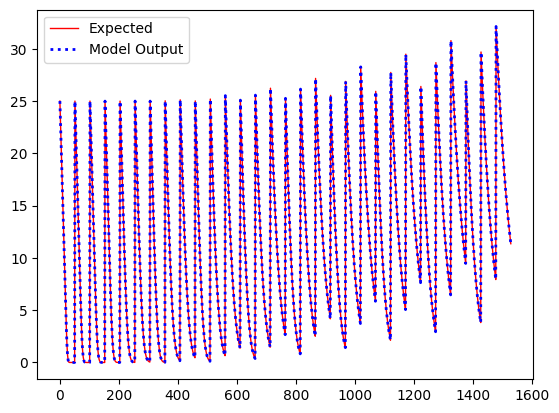

In [30]:
# NBVAL_IGNORE_OUTPUT
flatten = lambda x: list(map(lambda y: y[0], x))

plt.plot(df['OPRICE'], linewidth=1, color='red', label='Expected')
plt.plot(flatten(result), linewidth=2, color='blue', linestyle=':', label='Model Output')
plt.legend(loc="upper left")
plt.show()